In [233]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *
import pandas as pd

### The Duffing Equation is given by:

$ \dot{x_1} = x_2$

$ \dot{x_2} = -x_1^3+ax_1^2+x_1 - a $

### and the Hamiltonian is given by:

$ H = \frac{x_2^2}{2}+\frac{x_1^4}{4}-\frac{x_1^2}{2}-\frac{a}{3}x_1^3+ax_1$

In [223]:
# define the system ODE

def duffing(t,X,a):
    # define individual ODEs or rates of change
    dx1dt = X[1]
    dx2dt = -X[0]**3+a*X[0]**2+X[0]-a
    # collect rates of change
    dXdt = np.asarray([dx1dt,dx2dt])
    # return the result
    return dXdt


# define the hamiltonian for the system
def Hamiltonian(X,a):
    
    x1 = X[0]; x2 = X[1]
    
    H = (x2**2)/2+(x1**4)/4-(x1**2)/2-a/3*x1**3+a*x1
    
    return H

### Collect Trajectories

In [240]:
dt = 0.001 # time step
tspan = [0, 10] # initial and final time
t_vec = np.arange(0,10,dt) # time vector
x0 = [0, -2.8] # initial condition

a = 0 # parameter for the duffing equation

states = solve_ivp(duffing, tspan, x0, t_eval = t_vec , args = (a,))

t = states.t
X = states.y

Text(0.5, 1.0, 'Duffing System State Evolution')

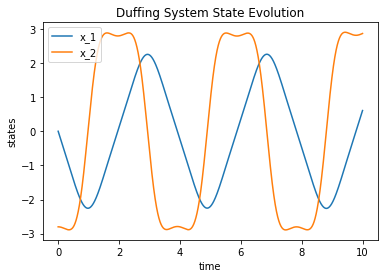

In [241]:
plt.plot(t,states.y[0,:],label = 'x_1')
plt.plot(t,states.y[1,:],label = 'x_2')
plt.legend()
plt.xlabel('time')
plt.ylabel('states')
plt.title('Duffing System State Evolution')

### Identify Koopman Eigenfunction with Lambda = 0 (Hamiltonian) from Full Trajectory for Truth/Reference

In [226]:
Hamilt = [Hamiltonian(X[:,i],a) for i in range(X.shape[1])]

### Compute Derivatives Using Fourth Order Central Difference

In [79]:
# Generic Fourth Order Central Difference
nstates = 2
dX = np.zeros([nstates,X.shape[1]-4])

for i in range(nstates):
    dX[i,:] = (1/(12*dt)) * (-X[i,4:] + 8*X[i,3:-1] - 8*X[i,1:-3] + X[i,:-4]) 

X = X[:,2:-2]

### Build Theta

In [82]:
def buildTheta(yin,polyorder,usesine):
    
    n = yin.shape[1]
    nVars = yin.shape[0]
    
    # zero order polynomial (constant)
    yout = np.ones([n,1])
    
    # first order polynomial
    for i in range(nVars):
        col = np.reshape(yin[i,:],(n,1))
        yout = np.append(col,yout,axis = 1)
       
    
    # second oder polynmial 
    if (polyorder >= 2):
        for i in range(nVars):
            for j in range(i,nVars):
                col = np.reshape(yin[i,:]*yin[j,:],(n,1))
                yout = np.append(col,yout,axis = 1)
    
    # third order polynomial
    if (polyorder >= 3):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    col = np.reshape(yin[i,:]*yin[j,:]*yin[k,:],(n,1))
                    yout = np.append(col,yout,axis = 1)
    
    # fourth order polynomial
    if (polyorder >= 4):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    for l in range(k,nVars):
                        col = np.reshape(yin[i,:]*yin[j,:]*yin[k,:]*yin[l,:],(n,1))
                        yout = np.append(col,yout,axis = 1)
    
    # sines
    if(usesine):
        for i in range(nVars):
            for j in range(1,11):
                col = np.reshape(np.sin(j*yin[i,:]),(n,1))
                yout = np.append(col,yout,axis = 1)
                col = np.reshape(np.cos(j*yin[i,:]),(n,1))
                yout = np.append(col,yout,axis = 1)
                                 
    return yout

### Build Gamma

In [83]:
def buildGamma(yin,ydotin,polyorder,usesine):
    
    n = yin.shape[1]
    nVars = yin.shape[0]
    
    # derivative of zero order polynomial (constant)
    yout = np.zeros([n,1])
    
    # derivative of first order polynomial
    for i in range(nVars):
        col = np.reshape(ydotin[i,:],(n,1))
        yout = np.append(col,yout,axis = 1)
        
    # derivative of second order polynomial
    if (polyorder >= 2):
        for i in range(nVars):
            for j in range(i,nVars):
                col = np.reshape(ydotin[i,:]*yin[j,:]+yin[i,:]*ydotin[j,:],(n,1))
                yout = np.append(col,yout,axis = 1)
    
    # third order polynomial
    if (polyorder >= 3):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    col = (np.reshape(ydotin[i,:]*yin[j,:]*yin[k,:]+yin[i,:]*ydotin[j,:]*yin[k,:]
                                      +yin[i,:]*yin[j,:]*ydotin[k,:],(n,1)))
                    yout = np.append(col,yout,axis = 1)
                    
    # fourth order polynomial
    if (polyorder >= 4):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    for l in range(k,nVars):
                        col = (np.reshape(ydotin[i,:]*yin[j,:]*yin[k,:]*yin[l,:]
                                          +yin[i,:]*ydotin[j,:]*yin[k,:]*yin[l,:]
                                          +yin[i,:]*yin[j,:]*ydotin[k,:]*yin[l,:]
                                          +yin[i,:]*yin[j,:]*yin[k,:]*ydotin[l,:],(n,1)))
                        yout = np.append(col,yout,axis = 1)
    
    
    # sines
    if(usesine):
        for i in range(nVars):
            for j in range(1,11):
                col = np.reshape(np.sin(j*yin[i,:]),(n,1))
                yout = np.append(col,yout,axis = 1)
                col = np.reshape(np.cos(j*yin[i,:]),(n,1))
                yout = np.append(col,yout,axis = 1)
    
    return yout


In [85]:
Theta = buildTheta(X,4,False)
Gamma = buildGamma(X,dX,4,False)

### Compute the SVD

In [221]:
U,Sigma,VT = np.linalg.svd(0*Theta-Gamma,full_matrices=0)
V = VT.T
K = np.dot(np.linalg.pinv(Theta),Gamma)
thresh_ind = np.where(np.abs(K) < 1e-6)
K[thresh_ind] = 0
[D,T] = np.linalg.eig(K)

IX = np.argsort(np.abs(D))
xi1 = T[IX[0],:]
xi0 = V[:,-1]

# # corrections for scaling
# xi0 = 1/2*xi0/xi0[2]
# xi1 = 1/2*xi1/xi1[2]

In [222]:
K

array([[ 1.33008530e-02,  6.86770140e+00, -4.44530975e-02,
         2.94939898e-02, -8.14418990e-03, -6.19220636e-01,
         9.64242318e-03, -9.75196533e-04, -1.44952732e-03,
        -4.43451509e-03,  3.82169518e-03, -1.28172930e-03,
         1.16777540e-03, -1.37759313e-04,  0.00000000e+00],
       [-1.90090687e+01,  7.65574990e-03,  5.94831977e+00,
         5.04014792e-04, -2.44250797e-04,  4.58980842e-02,
         2.19371265e-03, -3.29060739e-03,  5.40080793e-04,
        -8.60342991e-03,  4.64097368e-04, -4.88189038e-05,
        -4.69900508e-04,  3.40182633e-05,  0.00000000e+00],
       [ 4.50974458e-02, -3.52580209e+00, -1.27092783e-01,
         5.03801275e+00, -2.32858034e-02, -1.39699959e+00,
         1.09768795e-02, -8.52169853e-03, -3.95114763e-03,
        -1.12303987e-02, -2.64513819e-03, -3.85442965e-03,
         2.72247818e-03, -4.16140145e-04,  0.00000000e+00],
       [-4.19412036e+01,  2.54659248e-03, -2.09059788e+00,
         6.61770668e-03,  4.00234275e+00,  1.05407737

In [228]:
blah1 = np.dot(Theta,xi0)
blah2 = np.dot(Theta,xi1*(3/4))

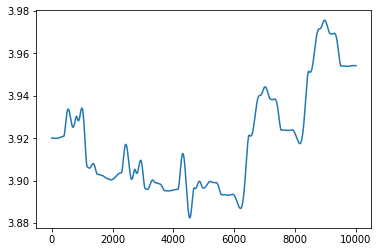

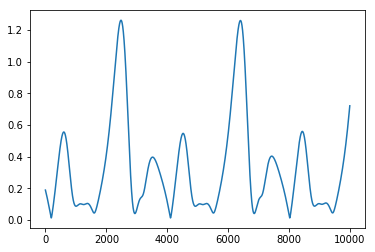

In [232]:
plt.plot(Hamilt)
plt.show()
plt.plot(np.abs(blah2))
plt.show()


In [214]:
xi0

array([ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.])